In [345]:
import numpy as np
import torch
import torchvision

import torchvision.transforms as transforms
from datasets import SynthDataset
from synth_utils import js_div, kl_div, pca
from priors import FactorizedNormalPrior
import torch.nn.functional as F

from matplotlib import pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset

In [346]:
img_size = 32
transform = transforms.Compose(
    [transforms.Scale(img_size),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=50,
                                          shuffle=True, num_workers=2)

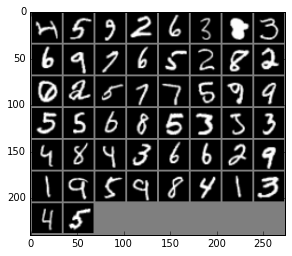

In [347]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

## BGAN-NG

In [348]:
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

In [349]:
trainset[0][0].size()

torch.Size([1, 32, 32])

In [358]:
# class GeneratorNetwork(nn.Module):
    
#     def __init__(self, shape, num_samples, init=None):
#         super(GeneratorNetwork, self).__init__()
#         self.build_net(shape, num_samples, init)
#         self.output_dim = shape
    
#     def build_net(self, shape, num_samples, init):
#         if init is None:
#             z = torch.from_numpy(np.random.normal(size=[num_samples] + shape)).float()
#         else:
#             z = torch.from_numpy(init).float()
#         self.z_v = Variable(z.cuda(), requires_grad=True)
    
    
#     def forward(self):
#         output = F.tanh(self.z_v)
#         return output
    
#     def parameters(self):
#         return [self.z_v]
    
class GeneratorNetwork(nn.Module):
    # initializers
    def __init__(self, d=128, z_dim=100):
        super(GeneratorNetwork, self).__init__()
        self.init_net(d, z_dim)
        self.input_dim = z_dim
        input_ = torch.from_numpy(np.random.rand(1, self.input_dim, 1, 1))
        input_ = input_.float()
        input_ = input_#.cuda()
        self.input = nn.Parameter(input_, requires_grad=True)
        
    def init_net(self, d, z_dim):
        self.deconv1 = nn.ConvTranspose2d(z_dim, d*4, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d*4)
        self.deconv2 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*2)
        self.deconv3 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d)
        self.deconv4 = nn.ConvTranspose2d(d, 1, 4, 2, 1)

    # forward method
    def forward(self):
#         x = Variable(torch.zeros(x.size()[0], self.input_dim, 1, 1)).cuda()
#         x = x.view((-1, self.input_dim, 1, 1))
        x = self.input
#         x = self.linear1()
        x = F.relu(self.deconv1_bn(self.deconv1(x)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.tanh(self.deconv4(x))

        return x
    
#         return x

def weight_init(m):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.zero_()

class DiscriminatorNetwork(nn.Module):
    
    def __init__(self, d=128):
        super(DiscriminatorNetwork, self).__init__()
        self.init_net(d)
    
    # initializers
    def init_net(self, d):
        self.conv1 = nn.Conv2d(1, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, 1, 4, 1, 0)

    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.sigmoid(self.conv4(x))
        x = x.squeeze()

        return x

In [359]:
from bgan_nogen import BGANNG, FixedSizeDataset

In [360]:
batch_size = 50
z_init = np.copy(trainset[123][0].numpy())[None, :]

In [383]:
prior = FactorizedNormalPrior(std=5.)
disc = DiscriminatorNetwork()
# gen = GeneratorNetwork([1, img_size, img_size], 1, init=z_init)
gen = GeneratorNetwork(z_dim=10, d=5)
gen.apply(weights_init)
bgan = BGANNG(gen, prior, disc, alpha=.01, eta=2e-4, num_data=len(trainset), disc_lr=2e-4, cuda=True, MAP=False)
disc.apply(weights_init)
samples = []

Moving generator and discriminator to GPU


In [384]:
num_params = 0
for param in gen.parameters():
    num_params += np.prod(param.size())
    print(param.size(), np.linalg.norm(param.cpu().data.numpy()))
print('Total:', num_params)

torch.Size([1, 10, 1, 1]) 1.48448
torch.Size([10, 20, 4, 4]) 2.59329
torch.Size([20]) 0.203324
torch.Size([20]) 2.72189
torch.Size([20]) 0.0
torch.Size([20, 10, 4, 4]) 1.82032
torch.Size([10]) 0.104089
torch.Size([10]) 2.07477
torch.Size([10]) 0.0
torch.Size([10, 5, 4, 4]) 1.26786
torch.Size([5]) 0.0446068
torch.Size([5]) 1.46095
torch.Size([5]) 0.0
torch.Size([5, 1, 4, 4]) 0.59078
torch.Size([1]) 0.016486
Total: 7396


In [385]:
# z_init = np.copy(trainset[123][0].numpy())[None, :]
# bgan.generator = GeneratorNetwork([1, 28, 28], 1, init=z_init)
# bgan.generator.cuda()
# plt.imshow(bgan.generator.forward().data.numpy()[0, 0])

In [491]:
old_samples = None
if isinstance(samples, np.ndarray):
    old_samples = np.copy(samples)
    samples = []
for epoch in range(200):
    for i, data_ in enumerate(trainloader, 0):

        batch = data_[0].float()
        bgan.step(batch)
        if not i%100:
#             print(i)
            bgan.fake_dataset.append(np.copy(gen.forward().cpu().data.numpy()[0, :]))
    if not epoch%1:
        samples.append(np.copy(gen.forward().cpu().data.numpy()))
    if not epoch%1:
        batchv = Variable(batch).cuda()
        print(epoch)
        d_loss, g_loss = bgan.loss(batchv)
        print('\t', d_loss.cpu().data.numpy()[0], g_loss.cpu().data.numpy()[0])
        
if old_samples is not None:
    samples = np.vstack([old_samples, np.array(samples)])
else:
    samples = np.array(samples)

0
	 2.92528e-10 1.14442e-05
1
	 3.27501e-10 8.58311e-06
2
	 6.57936e-10 9.29837e-06
3
	 1.12311e-09 1.20402e-05
4
	 2.4654e-11 2.5034e-06
5
	 2.48253e-11 1.66893e-06
6
	 1.97664e-11 1.19209e-06
7
	 1.74716e-11 9.53675e-07
8
	 1.70395e-11 1.19209e-06
9
	 6.6544e-10 1.07288e-06
10
	 1.06219e-09 4.52996e-06
11
	 2.16209e-10 6.67574e-06
12
	 7.04304e-11 7.62942e-06


KeyboardInterrupt: 

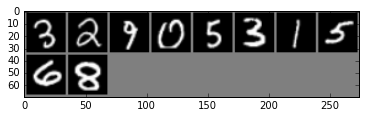

In [479]:
imshow(torchvision.utils.make_grid(batch[:10]))

In [480]:
fake_samples = []
for sample in bgan.fake_dataset:
    fake_samples.append(sample)
fake_samples = np.array(fake_samples)

In [481]:
# samples.append(np.copy(gen.forward().cpu().data.numpy()))

In [482]:
samples = [np.array(sample).reshape((1, 1, 32, 32)) for sample in samples]

In [483]:
samples_arr = np.vstack(samples)

In [484]:
samples_arr.shape

(140, 1, 32, 32)

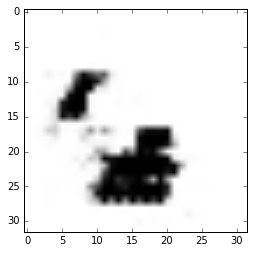

In [485]:
plt.imshow(1 - (samples_arr[-1, 0] + 1)/2, cmap='gray')

In [486]:
np.max(batch.numpy())

1.0

In [487]:
samples_arr.shape

(140, 1, 32, 32)

In [488]:
# samples_arr[samples_arr < 0] = -1
# samples_arr[samples_arr > 0] = 1

# fake_samples[fake_samples < 0] = -1
# fake_samples[fake_samples > 0] = 1

In [489]:
# np.where(np.isnan(samples_arr))
# samples_arr = samples_arr[:4594]

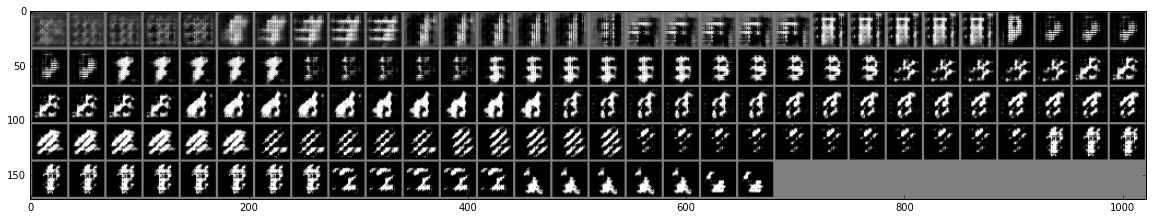

In [490]:
plt.figure(figsize=(20, 50))
imshow(torchvision.utils.make_grid(torch.from_numpy(samples_arr[:]), nrow=30))


In [451]:
thinned_samples = []
thinning_rate = 10
num_thinned = int(len(samples_arr) / thinning_rate)
indices = np.arange(num_thinned) * thinning_rate
thinned_samples = samples_arr[indices]

# for i, sample in samples_arr:

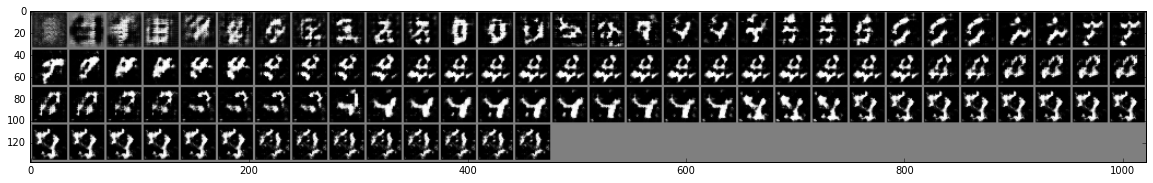

In [344]:
plt.figure(figsize=(20, 50))
imshow(torchvision.utils.make_grid(torch.from_numpy(thinned_samples), nrow=30))

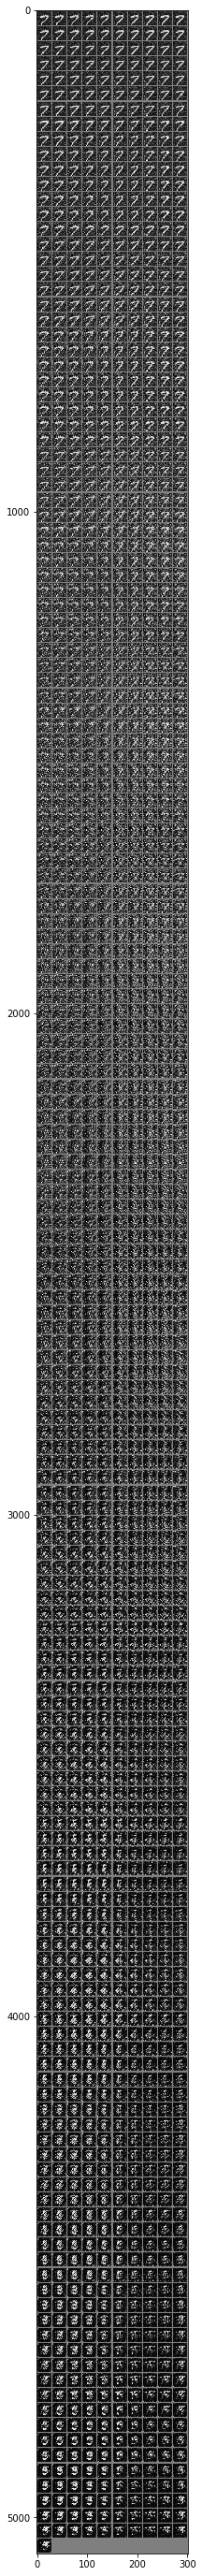

In [595]:
plt.figure(figsize=(20, 50))
imshow(torchvision.utils.make_grid(torch.from_numpy(fake_samples[:]), nrow=10))


In [166]:
sample_probs = bgan.discriminator(Variable(torch.from_numpy(samples_arr[-100:]).float()).cuda())

In [167]:
sample_probs

Variable containing:
1.00000e-07 *
  1.5671
  1.5671
  1.5671
  1.5671
  1.5671
  1.5671
  1.5671
  1.5671
  1.5671
  1.5671
[torch.cuda.FloatTensor of size 10 (GPU 0)]

In [168]:
disc(Variable(trainset[71][0][None, :].cuda()))

Variable containing:
 0.3868
[torch.cuda.FloatTensor of size 1 (GPU 0)]

In [169]:
disc(Variable(batch).cuda())

Variable containing:
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
 1.0000
[torch.cuda.FloatTensor of size 50 (GPU 0)]

In [294]:
# torch.save(bgan.discriminator.state_dict(), 'disc_weights.pt')
# disc.load_state_dict(torch.load('disc_weights.pt'))
# for param1, param2 in list(zip(disc.parameters(), bgan.discriminator.parameters())):
#     print(np.linalg.norm(param1.cpu().data.numpy() - param2.cpu().data.numpy()))